# Computer Vision, Assignment 3: Epipolar Geometry

In this assignment, you will study epipolar geometry. 
You will use the fundamental matrix and the essential matrix for simultaneously reconstructing the 3D structure and the camera motion from two images.

Please see Canvas for detailed instructions on what is expected for a passing/higher grade.
All computer exercises that are not marked **OPTIONAL** are ``mandatory'' in the sense described on Canvas.


### Submission Requirements:
Your final lab submission should include:
1. Your edited **notebook file** (`.ipynb`).
2. An **HTML printout** of the executed notebook with all outputs visible: File → Save and export Notebook As → HTML
3. A **pdf report** containing answers to the theoretical exercises (see separate document).

In [1]:
# for creating responsive plots
%matplotlib widget  

import cv2
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.io

from supplied import pflat, plot_camera, rital,camera_center_and_axis

# The Fundamental Matrix

#### *Theoretical exercises 1-4* (see pdf)

## Computer Exercise 1
<figure align="center">
    <img alt="left" src="data/kronan1.JPG" width="250px">
&nbsp; &nbsp; &nbsp; &nbsp;
    <img alt="right" src="data/kronan2.JPG" width="250px">
    <figcaption>Figure1. kronan1.jpg and kronan2.jpg</figcaption>
</figure>

In this exercise you will compute the fundamental matrix for the two images above, showing a part of the fort Kronan in Gothenburg. The calibration matrix $K$ is assumed to be unknown. The file `compEx1data.mat` contains a cell `x` with matched points for the two images.

### Task 1.1
Compute normalization matrices $N_1$ and $N_2$. These matrices should subtract the mean and re-scale using the standard deviation, as in assignment 2.
Normalize the image points of the two images with $N_1$ and $N_2$, respectively.

In [2]:
# ------ Your code here ------

# Compute N1 and N2
data1 = scipy.io.loadmat('data/compEx1data.mat')
x=data1['x']
x1=x[0,0]
x2=x[1,0]
uc1,vc1=np.mean(x1[:2,:],axis=1)
uc2,vc2=np.mean(x2[:2,:],axis=1)
d1 = np.mean(np.sqrt((x1[0,:]-uc1)**2 + (x1[1,:]-vc1)**2))
d2 = np.mean(np.sqrt((x2[0,:]-uc2)**2 + (x2[1,:]-vc2)**2))
s1 = np.sqrt(2) / d1
s2 = np.sqrt(2) / d2
N1=np.array([[s1,0,-s1*uc1],
            [0,s1,-s1*vc1],
            [0,0,1]])
N2=np.array([[s2,0,-s2*uc2],
            [0,s2,-s2*vc2],
            [0,0,1]])

# Normalize the image points
x1n =pflat(N1@x1)
x2n =pflat(N2@x2)

### Task 1.2
Set up the matrix $M$ in the eight point algorithm (8 is the minimum number of points, you should use all the points here), and solve the homogeneous least squares system using SVD. 
Check that the minimum singular value and $||Mv||$ are both small. Construct the $3 \times 3$ matrix $\tilde F$ from the solution $v$. This matrix should approximately satisfy $\tilde x_2^T \tilde F \tilde x_1 = 0$, where $\tilde x_j$ are normalized image points. Write the code as a function which would be useful later. 

In [3]:
def estimate_F_DLT(x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    '''
    # Your code here
    u1,v1=x1s[0,:], x1s[1,:]
    u2,v2=x2s[0,:], x2s[1,:]
    A = np.column_stack([
    u2*u1,
    u2*v1,
    u2,
    v2*u1,
    v2*v1,
    v2,
    u1,
    v1,
    np.ones_like(u1)
    ])
    U, S, Vt = np.linalg.svd(A)
    f=Vt[-1,:]
    F = f.reshape(3, 3)
    return F



You must also make sure that $\det(\tilde{F}) = 0$ for your solution. Make a separate function that explicitly enforces the constraint, as this will be convenient for you later.

In [4]:
def enforce_fundamental(F_approx):
    '''
    F_approx - Approximate Fundamental matrix (3x3)
    '''
    # Your code here
    U, S, Vt = np.linalg.svd(F_approx)
    S[2] = 0
    F = U @ np.diag(S) @ Vt
    return F


Estimate $\tilde{F}$ and check that the epipolar constraints $\tilde{x}_2^T \tilde{F} \tilde{x}_1 = 0$ are roughly fulfilled.


In [5]:
# ------ Your code here ------

# Estimate F_tilde 
F=estimate_F_DLT(x1n, x2n)
F=enforce_fundamental(F)
# Check epipolar constraints
epipolar_errors = np.sum(x2n * (F @ x1n), axis=0)
print("Epipolar errors :", epipolar_errors)
print("Mean abs error:", np.mean(np.abs(epipolar_errors)))



Epipolar errors : [ 5.62653333e-05  1.45215945e-03  7.15874536e-04 ... -3.98084660e-04
  3.33689409e-04 -8.12624059e-04]
Mean abs error: 0.0006718159520039346


### Task 1.3



Compute the un-normalized fundamental matrix $F$ (using the formula from exercise 4) and the epipolar lines $l = F x_1$. Pick 20 points in the second image at random and plot these in the same figure as the image.
Also plot the corresponding epipolar lines in the same image using the function `rital`. Verify that the points are close to the corresponding epipolar lines.





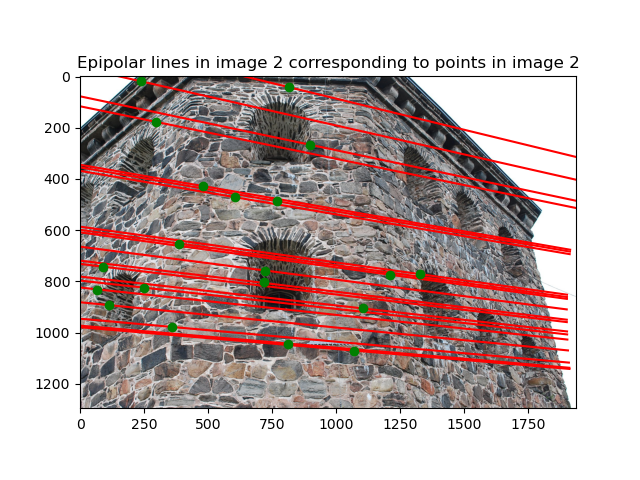

In [6]:
# ------ Your code here ------ 

# Compute un-normalized F
F_unnormalized = N2.T @ F @ N1
# Compute epipolar lines
l2=F_unnormalized@x1

# Visualize epipolar lines and corresponding points and check that epipolar constraints roughly fulfilled
img2=mpimg.imread('data/kronan2.JPG')
idx=np.random.choice(x1.shape[1],20,replace=False)  
x2_sample=x2[:,idx]
plt.figure(num=1)
plt.imshow(img2)
li=l2[:,idx]
rital(li.T,st='r-')
plt.plot(x2_sample[0,:],x2_sample[1,:],'go')
plt.title('Epipolar lines in image 2 corresponding to points in image 2')
plt.show()


Compute the distance between all the points and their corresponding epipolar lines and plot these in a histogram with 100 bins.
What is the mean distance? Create a function as this would be useful later.

In [7]:
def compute_epipolar_errors(F, x1s, x2s):
    '''
    x1s and x2s contain matching points
    x1s - 2D image points in the first image in homogenous coordinates (3xN)
    x2s - 2D image points in the second image in homogenous coordinates (3xN)
    F - Fundamental matrix (3x3)
    '''
    # Your code here
    l2=F @ x1s
    d2=np.abs(np.sum(l2 * x2s, axis=0)) / np.sqrt(l2[0,:]**2 + l2[1,:]**2)
    return d2


Mean epipolar distance: 0.3567547837090026


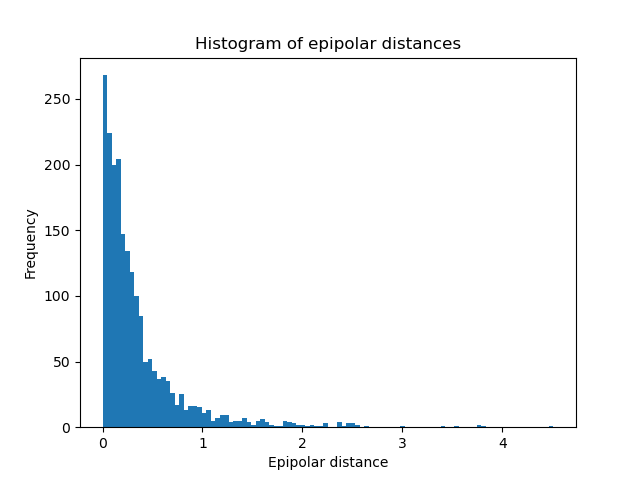

In [8]:
# ------ Your code here ------

# Compute mean epipolar distance
d2=compute_epipolar_errors(F_unnormalized, x1, x2)
d_mean=np.mean(d2)
print("Mean epipolar distance:", d_mean)
# Plot epipolar distances in a histogram
plt.figure()
plt.hist(d2, bins=100)
plt.title('Histogram of epipolar distances')
plt.xlabel('Epipolar distance')
plt.ylabel('Frequency')
plt.show()

#### Your answer here: 

The mean distance with normalization is: 
 0.3567547837090026

### Task 1.4

See what happens if we do everything without normalization (that is, set $N_1=N_2=I$ and run the code again).
What is the mean distance in this case?

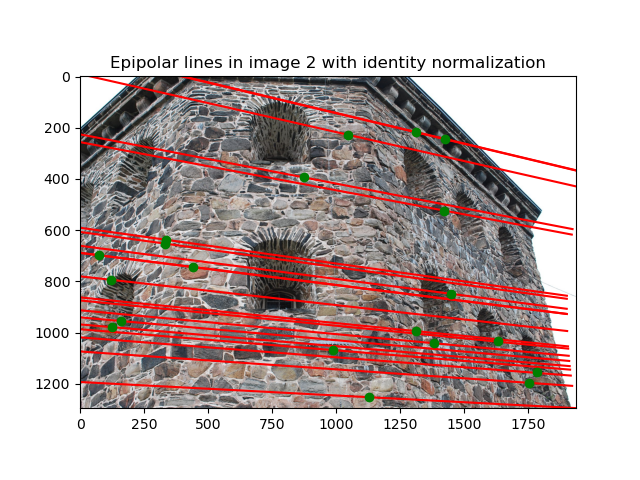

Mean epipolar distance with identity normalization: 0.4878403581261155


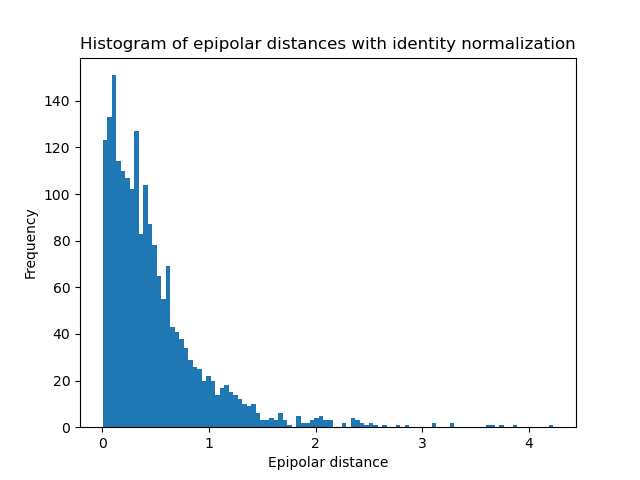

In [9]:
# ------ Your code here ------

# See what happens if N1=N2=I
F_identity=estimate_F_DLT(x1, x2)
F_identity=enforce_fundamental(F_identity)
img2=mpimg.imread('data/kronan2.JPG')
idx=np.random.choice(x1.shape[1],20,replace=False)
x2_sample=x2[:,idx]
l2_identity=F_identity@x1[:,idx]
plt.figure()
plt.imshow(img2)
rital(l2_identity.T,st='r-')
plt.plot(x2_sample[0,:],x2_sample[1,:],'go')
plt.title('Epipolar lines in image 2 with identity normalization')
plt.show()
# Compute mean epipolar distance for this case
d2_identity=compute_epipolar_errors(F_identity, x1, x2)
d_mean_identity=np.mean(d2_identity)
print("Mean epipolar distance with identity normalization:", d_mean_identity)
plt.figure()
plt.hist(d2_identity, bins=100)
plt.title('Histogram of epipolar distances with identity normalization')
plt.xlabel('Epipolar distance')
plt.ylabel('Frequency')
plt.show()

#### Your answer here: 

The mean distance without normalization is:0.4878403581261155


#### *Theoretical exercise 5* (see pdf)

# The Essential Matrix

#### *Theoretical exercise 6* (see pdf)

## Computer Exercise 2


### Task 2.1

The file `compEx2data.mat` contains the calibration matrix $K$ for the two images in Computer Exercise 1. 
Normalize the image points using the inverse of $K$.

Set up the matrix $M$ in the eight point algorithm, and solve the homogeneous least squares system using SVD. Check that the minimum singular value and $Mv$ are both small. You can of course re-use function `estimate_F_DLT`.

Construct the essential matrix from the solution $v$. Don't forget to make sure that $E$ has two equal singular values and the third one zero.
As the essential matrix is a homogeneous entity, scale does not matter, but for grading purposes, please also make sure that the two non-zero singular values are both equal to 1.
Check that the epipolar constraints $\tilde{x}_2^T E\tilde{x}_1 = 0$ are roughly fulfilled.

In [10]:
def enforce_essential(E_approx):
    '''
    E_approx - Approximate Essential matrix (3x3)
    '''
    # Your code here
    U, S, Vt = np.linalg.svd(E_approx)
    if np.linalg.det(U) < 0:
        U[:, -1] *= -1
    if np.linalg.det(Vt) < 0:
        Vt[-1, :] *= -1
    Sigma = np.diag([1, 1, 0])
    E = U @ Sigma @ Vt
    return E

In [11]:
# ------ Your code here ------

# Normalize the image points 
data2=scipy.io.loadmat('data/compEx2data.mat')
K=data2['K']
x1_n=np.linalg.inv(K)@x1
x2_n=np.linalg.inv(K)@x2
# Set up the matrix M in eight point algorithm and solve for v
u1,v1=x1_n[0,:], x1_n[1,:]
u2,v2=x2_n[0,:], x2_n[1,:]
M = np.column_stack([
    u2*u1,
    u2*v1,
    u2,
    v2*u1,
    v2*v1,
    v2,
    u1,
    v1,
    np.ones_like(u1)
    ])
U, S, Vt = np.linalg.svd(M)
v=Vt[-1,:]
# Check that minimum singular value and Mv both are small
print("Minimum singular value of M:", S[-1])
print("Norm of Mv:", np.linalg.norm(M @ v))
# Construct essential matrix from v (Ensuring that the two non-zero singular values are both equal to 1
E=v.reshape(3, 3)
E=enforce_essential(E)
# Check that epipolar constraints are roughly fulfilled
print("Epipolar errors:",np.sum(x2_n * (E @ x1_n), axis=0))


Minimum singular value of M: 0.006626799894543102
Norm of Mv: 0.0066267998945431315
Epipolar errors: [-0.00135914 -0.00148348 -0.00151998 ... -0.00119198 -0.00035005
 -0.00155368]


### Task 2.2

Compute the fundamental matrix for the un-normalized coordinate system from the essential matrix and compute the epipolar lines $l = F  x_1$. Pick 20 of the detected points in the second image
at random and plot these in the same figure as the image. Also plot the corresponding epipolar lines in the same figure using the function `rital`.

Compute the distance between the points and their corresponding epipolar lines and plot these in a histogram with 100 bins. 
**How does this result compare to the corresponding result in Computer Exercise 1?** If the errors are higher, remember that we are dealing with noisy measurements, and for the essential matrix we enforce more constraints than for the fundamental matrix. Write the following function that will be helpful for the rest of the course.

In [12]:
# Note that we in this case have K1=K2=K

def convert_E_to_F(E,K1,K2):
    '''
    A function that gives you a fundamental matrix from an essential matrix and the two calibration matrices
    E - Essential matrix (3x3)
    K1 - Calibration matrix for the first image (3x3)
    K2 - Calibration matrix for the second image (3x3)
    '''
    # Your code here
    F=np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
    return F

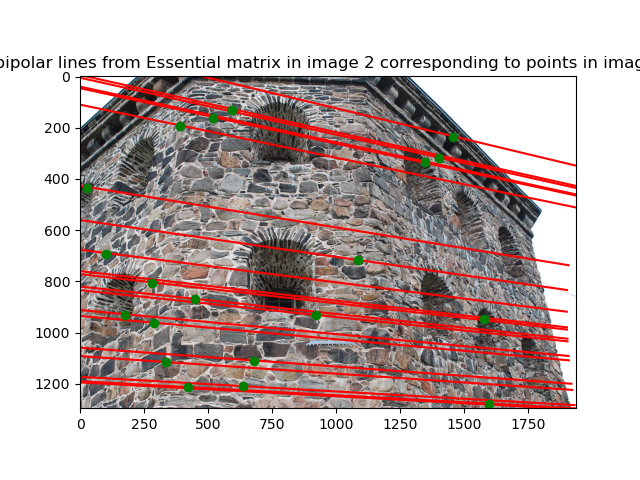

Mean epipolar distance from Essential matrix: 2.083753202690888


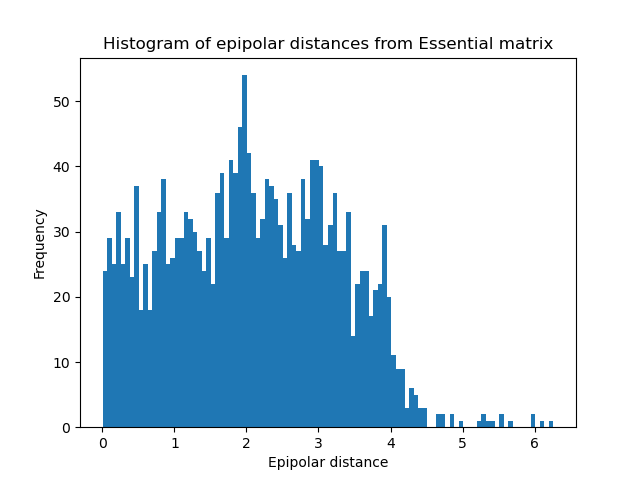

In [13]:
# ------ Your code here ------

# Compute the fundamental matrix from the essential matrix and compute the epipolar lines
F_from_E=convert_E_to_F(E, K, K)
l2_from_E=F_from_E@x1
# Plot 20 of the detected points and corresponding epipolar lines in the same figure as the image
idx=np.random.choice(x1.shape[1],20,replace=False)
x2_sample=x2[:,idx]
li_from_E=l2_from_E[:,idx]
plt.figure()
plt.imshow(img2)
rital(li_from_E.T,st='r-')
plt.plot(x2_sample[0,:],x2_sample[1,:],'go')
plt.title('Epipolar lines from Essential matrix in image 2 corresponding to points in image 2')
plt.show()
# Compute the distance between the points and their corresponding epipolar lines and plots these in a histogram
d2_from_E=compute_epipolar_errors(F_from_E, x1, x2)
d_mean_from_E=np.mean(d2_from_E)
print("Mean epipolar distance from Essential matrix:", d_mean_from_E)
plt.figure()
plt.hist(d2_from_E, bins=100)
plt.title('Histogram of epipolar distances from Essential matrix')
plt.xlabel('Epipolar distance')
plt.ylabel('Frequency')
plt.show()


### Your answer here: 

(*Include an answer to the question marked in bold.*)
#
“The errors are higher than those in Exercise 1, and the histogram shows a much wider distribution of errors.

#### *Theoretical exercise 7* (see pdf)

## Computer Exercise 3


### Task 3.1

\begin{equation}
P_2 = [UWV^T \ u_3] \text{ or } [UWV^T \ -u_3]  \text{ or }
[UW^TV^T \ u_3]  \text{ or } [ UW^TV^T \ -u_3 ]
\end{equation}


For the essential matrix obtained in Computer Exercise 2 compute the four camera solutions above (make sure that `det(U*V') > 0`; otherwise set `V = -V`).

Write a function that does this for you, it will also be useful in the future. The output `P` should contain all four solutions.

In [14]:
def extract_P_from_E(E):
     '''
    A function that extract the four P2 solutions given above
    E - Essential matrix (3x3)
    P - Array containing all four P2 solutions (4x3x4) (i.e. P[i,:,:] is the ith solution) 
    '''
    # Your code here
     P=np.zeros((4, 3, 4))
     U, S, Vt = np.linalg.svd(E)
     if np.linalg.det(U) < 0:
          U[:, -1] *= -1
     if np.linalg.det(Vt) < 0:
          Vt[-1, :] *= -1
     W = np.array([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])
     t = U[:, 2]
     P[0, :, :] = np.hstack((U @ W @ Vt, t.reshape(3, 1)))
     P[1, :, :] = np.hstack((U @ W @ Vt, -t.reshape(3, 1)))
     P[2, :, :] = np.hstack((U @ W.T @ Vt, t.reshape(3, 1)))
     P[3, :, :] = np.hstack((U @ W.T @ Vt, -t.reshape(3, 1)))
     return P

In [15]:
# ------ Your code here ------

# Extract P2 from E 
P2_candidates=extract_P_from_E(E)


Triangulate the points using DLT for each of the four camera solutions, and determine for which of the solutions the points are in front of the cameras.
In this exercise, you may expect to have only one solution for which all the 3D points are in front of both cameras. But in general, since there is noise involved it might not be possible to find a solution with all points in front of the cameras. (In that case the solution with the highest number of points in front of the cameras needs to be selected.)

In [16]:
# ------ Your code here ------

# Triangulate the points using DLT for each of the four camera solutions
P1 = np.hstack((np.eye(3), np.zeros((3,1))))
Xs_candidates = np.zeros((4, 4, x1.shape[1]))
for i in range(4):
    P2 = P2_candidates[i, :, :]
    for j in range(x1.shape[1]):
        x1_j = x1_n[:, j]
        x2_j = x2_n[:, j]
        A = np.array([
            x1_j[0] * P1[2, :] - P1[0, :],
            x1_j[1] * P1[2, :] - P1[1, :],
            x2_j[0] * P2[2, :] - P2[0, :],
            x2_j[1] * P2[2, :] - P2[1, :]
        ])
        U, S, Vt = np.linalg.svd(A)
        X = Vt[-1, :]
        X = X / X[3]   
        Xs_candidates[i, :, j] = X
# Determine for which of the solutions the points are in front of the cameras
max_positive_depths = -1
best_solution_index = -1
for i in range(4):
    P2 = P2_candidates[i, :, :]
    Xs = Xs_candidates[i, :, :]
    Xs_cam1 = P1 @ Xs                
    Xs_cam2 = P2 @ Xs               
    depths1 = Xs_cam1[2, :]           
    depths2 = Xs_cam2[2, :]
    positive_depths = np.sum((depths1 > 0) & (depths2 > 0))
    print("Solution", i, "has", positive_depths, "points in front of both cameras")
    if positive_depths > max_positive_depths:
        max_positive_depths = positive_depths
        best_solution_index = i
print("Best solution index:", best_solution_index)


Solution 0 has 2008 points in front of both cameras
Solution 1 has 0 points in front of both cameras
Solution 2 has 0 points in front of both cameras
Solution 3 has 0 points in front of both cameras
Best solution index: 0


Compute the corresponding camera matrices for the original (un-normalized) coordinate system and plot the image points and the projected 3D-points in the same figure.
**Do the errors look small?**
Verify that the projections are reasonably well aligned with the image points.

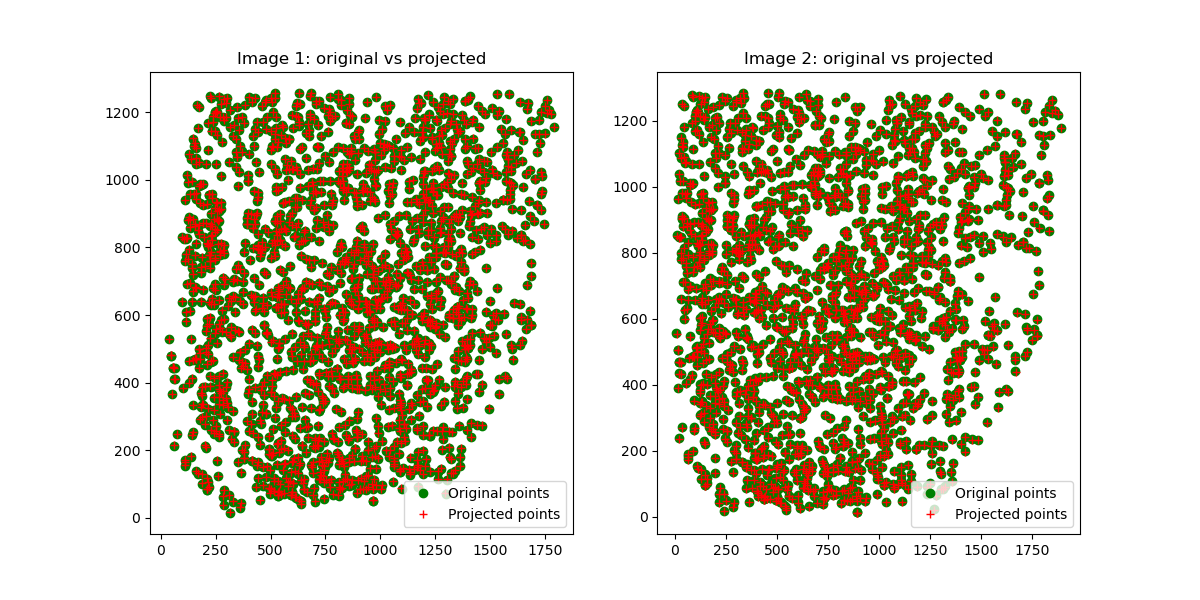

Reprojection errors for image 1: 0.9891562003151994
Reprojection errors for image 2: 1.0411589395331617


In [17]:
# ------ Your code here ------

# Compute the corresponding camera matrices for the original (un-normalized) coordinate system 
P1_unnormalized = K @ P1
P2_unnormalized = K @ P2_candidates[best_solution_index, :, :]  
# Plot the image points and the projected 3D-points in the same figure 

x1_proj = P1_unnormalized @ Xs_candidates[best_solution_index, :, :]
x1_proj = pflat(x1_proj)
x2_proj = P2_unnormalized @ Xs_candidates[best_solution_index, :, :]
x2_proj = pflat(x2_proj)
plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(12,6))

axes[0].plot(x1[0], x1[1], 'go', label='Original points')
axes[0].plot(x1_proj[0], x1_proj[1], 'r+', label='Projected points')
axes[0].set_title('Image 1: original vs projected')
axes[0].legend()

axes[1].plot(x2[0], x2[1], 'go', label='Original points')
axes[1].plot(x2_proj[0], x2_proj[1], 'r+', label='Projected points')
axes[1].set_title('Image 2: original vs projected')
axes[1].legend()

plt.show()

def reprojection_error(x, x_proj):
    errors = np.linalg.norm(x - x_proj, axis=0)
    return np.mean(errors)
print("Reprojection errors for image 1:", reprojection_error(x1, x1_proj))
print("Reprojection errors for image 2:", reprojection_error(x2, x2_proj))





Plot the 3D points and camera centers and principal axes in a 3D plot.
**Does it look like you expected it to ?**

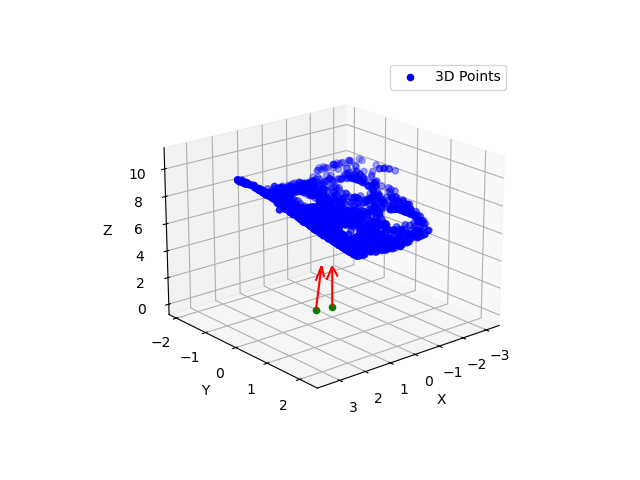

Text(0.5, 0.92, '3D Points and Camera Positions')

No such comm: 3697894c950a4c8999a9e09a51303292
No such comm: 3697894c950a4c8999a9e09a51303292
No such comm: 3697894c950a4c8999a9e09a51303292
No such comm: 3697894c950a4c8999a9e09a51303292
No such comm: 3697894c950a4c8999a9e09a51303292
No such comm: 3697894c950a4c8999a9e09a51303292


In [18]:
# ------ Your code here ------

# Plot the 3D points and camera centers and principal axes in a 3D plot 
Xs_world = np.zeros_like(Xs_candidates[best_solution_index])

P1u = P1_unnormalized
P2u = P2_unnormalized

for j in range(x1.shape[1]):
    u1 = x1[:, j]
    u2 = x2[:, j]

    A = np.array([
        u1[0] * P1u[2] - P1u[0],
        u1[1] * P1u[2] - P1u[1],
        u2[0] * P2u[2] - P2u[0],
        u2[1] * P2u[2] - P2u[1]
    ])

    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1, :]
    X /= X[-1]

    Xs_world[:, j] = X
plt.close('all')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs_world[0, :], Xs_world[1, :], Xs_world[2, :], c='b', marker='o', label='3D Points')

plot_camera(P1_unnormalized, 3, ax)

plot_camera(P2_unnormalized, 3, ax)



ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
ax.view_init(elev=20, azim=50)

plt.show()
ax.set_title('3D Points and Camera Positions')

### Your answer here: 

(*Include an answer to the question marked in bold.*)
#
The reprojection errors are within a few pixels on average, showing that the projections are well aligned with the original image points
In the 3D visualization, the reconstructed points form the rough shape of a wall, and the two camera centers with their principal axes are located in front of the wall, pointing towards it. This matches the expected geometry